In [46]:
%matplotlib widget

import caiman as cm 
import matplotlib.pyplot as plt
import numpy as np
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.params import CNMFParams 
from caiman.source_extraction.cnmf import cnmf
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour, view_quilt, inspect_correlation_pnr, nb_inspect_correlation_pnr 

# Source Extration for 1-Photon Calcium Imaging Data

## Preparing data for Source Extraction

In [2]:
fname = "../data/data_endoscope.tif"
movie_orig = cm.load(fname)

In [3]:
params = CNMFParams()
data_params = {
    'fr': 10,
    'decay_time': 0.4
}
params.data.update(data_params)

In [4]:
motion_params = {
    'pw_rigid': False,
    'gSig_filt': (3, 3), # important pre-processing step for 1p to remove low-frequency background activity
    'max_shifts': (5, 5),
    'strides': (48, 48),
    'overlaps': (24, 24),
    'max_deviation_rigid': 3
}
params.motion.update(motion_params)

In [5]:
mc = MotionCorrect(fname, **params.motion)
mc.motion_correct(save_movie=True)
mc.fname_tot_rig

['../data\\data_endoscope_rig__d1_128_d2_128_d3_1_order_F_frames_1000.mmap']

In [6]:
mc.motion_correct(save_movie=True)
mc_fname = mc.fname_tot_rig  
bord_px = 0  
fname_new = cm.save_memmap(mc_fname, base_name='memmap_', order='C', border_to_0=bord_px)

In [7]:
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

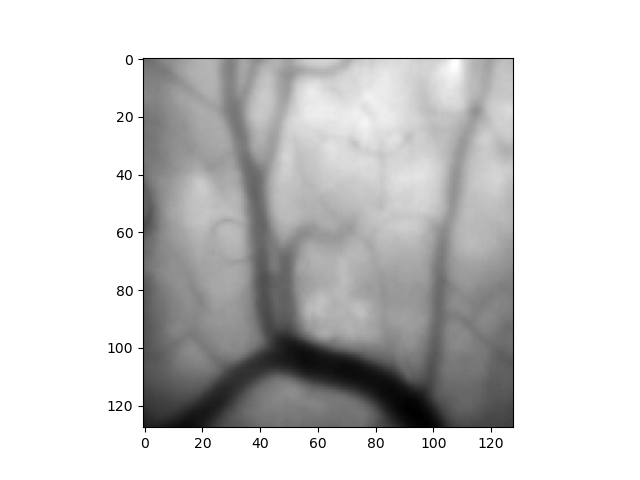

In [8]:
plt.imshow(np.median(images, axis=0), cmap='gray')

## Setting Parameters for 1-Photon Source Extraction

Things to remember:


```python
K = None # in general for CNMFE model
nb = 0 # tells caiman to use CNMFE algorithm where background is estimated using Ring Model
method_init = 'corr_pnr' # for 1 photon
nb_patch = 0 # number of background components per patch
only_init = True 
gSig = 3
gSiz = 2*gSig + 1
```

In [19]:
params

CNMFParams:

data:

{'caiman_version': '1.9.16',
 'decay_time': 0.4,
 'dims': None,
 'dxy': (1, 1),
 'fnames': None,
 'fr': 10,
 'last_commit': 'GITW-1f7104c60f9c90698383dc3d7a912648e528b156',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': 16384,
 'nb': 0,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_deconvolution': 'oasis',
 'nb': 0,
 'noise_method': 'mean',
 'noise_range': [0.25, 0.5],
 '

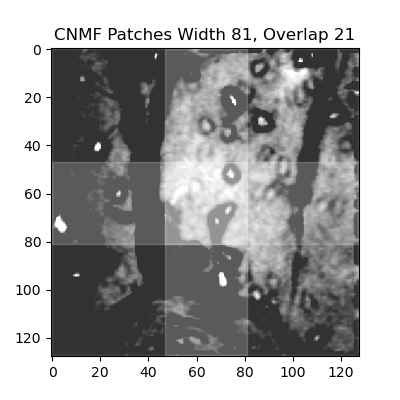

In [76]:
params.change_params(
    {
        'rf': 40,
        'stride': 20,
        'K': None,
        'nb': 0,
        'method_init': 'corr_pnr',
        'nb_patch': 0,
        'only_init': True,
        'gSig': np.array([3, 3]),
        'gSiz': np.array([7, 7]), #2*gSig+1,
        'center_psf': True
    }
)
cnmfe_model = cnmf.CNMF(n_processes=1, params=params)

cnmf_patch_width = cnmfe_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmfe_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap

correlation_image = cm.local_correlations(images, swap_dim=False)

patch_ax = view_quilt(correlation_image, 
                      cnmf_patch_stride, 
                      cnmf_patch_overlap, 
                      vmin=np.percentile(np.ravel(correlation_image),50), 
                      vmax=np.percentile(np.ravel(correlation_image),99.5),
                      figsize=(4,4));
patch_ax.set_title(f'CNMF Patches Width {cnmf_patch_width}, Overlap {cnmf_patch_overlap}');

In [93]:
# parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None for CNMFE
gSig = np.array([3, 3])  # expected half-width of neurons in pixels 
gSiz = 2*gSig + 1     # half-width of bounding box created around neurons during initialization
merge_thr = .7      # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels 
tsub = 2            # downsampling factor in time for initialization, increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization, increase if you have memory problems
gnb = 0             # number of background components (rank) if positive, set to 0 for CNMFE
low_rank_background = None  # None leaves background of each patch intact (use True if gnb>0)
nb_patch = 0        # number of background components (rank) per patch (0 for CNMFE)
min_corr = .8       # min peak value from correlation image
min_pnr = 10        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background (increase to 2 if slow)
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

params.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                # 'merge_thr': merge_thr,
                                'p': p,
                                # 'tsub': tsub,
                                # 'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                # 'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                # 'update_background_components': True,  # sometimes setting to False improve the results
                                # 'min_corr': min_corr,
                                # 'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # True for 1p
                                # 'ssub_B': ssub_B,
                                # 'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px});                # number of pixels to not consider in the borders)

cnmfe_model = cnmf.CNMF(n_processes=1, params=params)

In [94]:
cnmfe_fit = cnmfe_model.fit(images)

c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


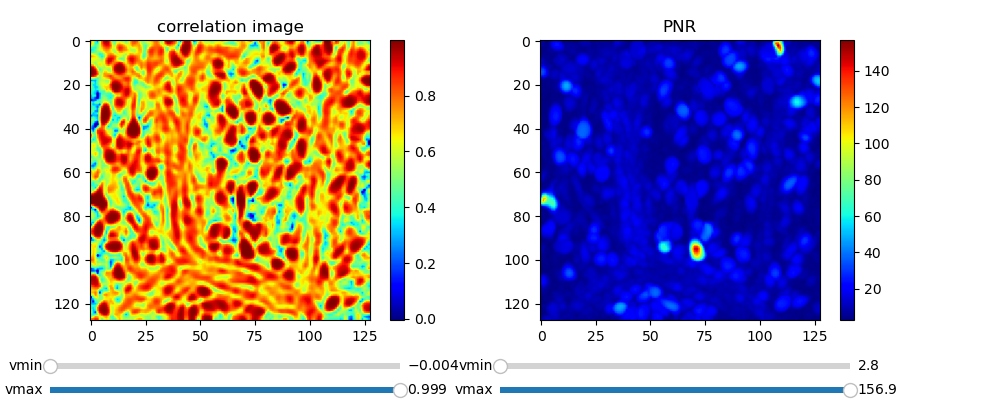

In [77]:

# removing low correlation/low pnr regions (high corr/high pnr means more neurons)

# calculate correlation and pnr maps for a subsample of frames (computational load reduction)

gsig = (3, 3)
correlation_image, peak_to_noise_ratio = cm.summary_images.correlation_pnr(images[::max(T//1000, 1)], # subsample if needed
                                                                           gSig=gsig[0], # used for filter
                                                                           swap_dim=False)

inspect_correlation_pnr(correlation_image, peak_to_noise_ratio) # jet, fire are also good cmaps

In [95]:
# adjust the slider such that you see mostly neuron pixels and not background/blood vessels. 
# Keep in mind that we need a lower bound and not the upper bound. If it is too large, we get false negatives

cnmfe_model.params.change_params(
    {
        'min_corr': 0.85,
        'min_pnr': 12
    }
)

CNMFParams:

data:

{'caiman_version': '1.9.16',
 'decay_time': 0.4,
 'dims': None,
 'dxy': (1, 1),
 'fnames': None,
 'fr': 10,
 'last_commit': 'GITW-1f7104c60f9c90698383dc3d7a912648e528b156',
 'mmap_C': None,
 'mmap_F': None,
 'var_name_hdf5': 'mov'}

spatial_params:

{'block_size_spat': 5000,
 'dist': 3,
 'expandCore': array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]),
 'extract_cc': True,
 'maxthr': 0.1,
 'medw': None,
 'method_exp': 'dilate',
 'method_ls': 'lasso_lars',
 'n_pixels_per_process': 16384,
 'nb': 0,
 'normalize_yyt_one': True,
 'nrgthr': 0.9999,
 'num_blocks_per_run_spat': 20,
 'se': None,
 'ss': None,
 'thr_method': 'nrg',
 'update_background_components': True}

temporal_params:

{'ITER': 2,
 'bas_nonneg': False,
 'block_size_temp': 5000,
 'fudge_factor': 0.96,
 'lags': 5,
 'memory_efficient': False,
 'method_deconvolution': 'oasis',
 'nb': 0,
 'noise_method': 'mean',
 'noise_range': [0.25, 0.5],
 '

## CNMFE for 1-Photon Microscopy Source Extraction

In [96]:
cnmfe_fit = cnmfe_model.fit(images)

c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]
c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_dia.py:339: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


## Exploring the Estimates Class

In [97]:
med_image = cm.local_correlations(images, swap_dim=False)
cnmfe_fit.estimates.plot_contours_nb(img=med_image);

In [98]:
cnmfe_fit.estimates.C.shape

(96, 1000)

In [99]:
import pandas as pd

frame_rate = cnmfe_fit.params.data['fr']
frame_pd = 1/frame_rate
frame_times = np.linspace(0, T*frame_pd, T);

data_to_save = np.vstack((frame_times, cnmfe_fit.estimates.S)).T  # Transpose so time series are in columns
save_df = pd.DataFrame(data_to_save)
save_df.rename(columns={0:'time'}, inplace=True)
save_df.head()


,time,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1001,0.000000,10.794951,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2002,0.000000,0.529082,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3003,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4004,10.643755,0.531941,0.0,0.0,0.0,0.19316,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


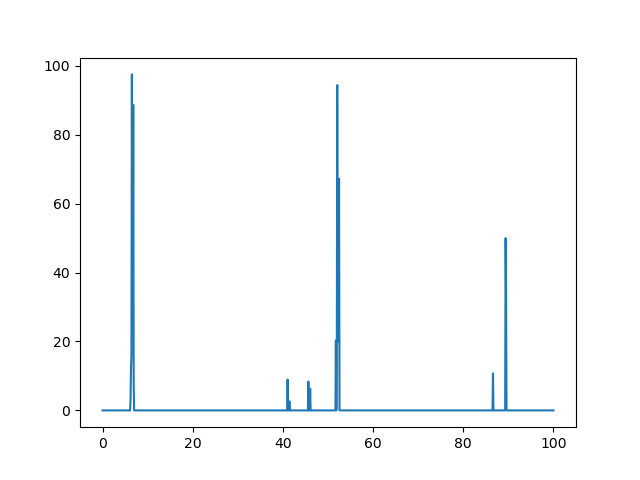

In [60]:
fig = plt.figure()
plt.plot(save_df.time, save_df[1])
plt.show()